# Word2Vec
### Miłosz Rolewski s473634

## Zadanie:
Dany jest zbiór tekstów dotyczących sportu:

https://gonito.csi.wmi.amu.edu.pl/challenge/sport-text-classification-ball

Jeżeli powyższy link nie działa, to tu: https://git.wmi.amu.edu.pl/kubapok/sport-text-classification-ball-ISI-public

Stwórz klasyfikator dwuklasowy (teksty "o piłce" / teksty "nie o piłce") bazujący na prostej sieci neuronowej (feed forward). Do reprezentowania tekstów użyj reprezentacji gęstej, takiej jak word2vec.

In [45]:
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix




[nltk_data] Downloading package punkt to /home/milosz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/milosz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Przygotowanie danych

In [38]:
TRAIN_DATA_PATH = "/home/milosz/Magister/uczenie_glebokie_part_2/02lab/sport-text-classification-ball-ISI-public/train/train.tsv"

bad_lines = []
with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if len(line.strip().split('\t')) != 2:
            bad_lines.append((i, line))
        else:
            text, label = line.strip().split('\t')


print(f"Znaleziono {len(bad_lines)} złych linii")
for line in bad_lines[:5]:
    print(f"    {line}")

df = pd.read_csv(
    TRAIN_DATA_PATH,
    sep="\t",
    header=None,
    names=["label", "text"],
    on_bad_lines='skip'  # <-- pomija błędne linie
)
df["tokens"] = df["text"].apply(lambda x: word_tokenize(x.lower()))

print(f"Znaleziono {len(df)} poprawnych linii")
display(df.head())



Znaleziono 3 złych linii
    (25705, '0\tGP3:\\\t Piąte miejsce w Soczi najlepszym wynikiem sezonu Artura Janosza Artur Janosz sięgnął w niedzielę po swój najlepszy rezultat w debiutanckim sezonie w będącej przedsionkiem Formuły 1 serii GP3. Podczas GP Rosji na torze w parku olimpijskim w Soczi polski kierowca ukończył drugi wyścig weekendu na 5. pozycji.\n')
    (58880, '1\tWysokie loty w Lublinie i Włocławku. Duet Washington - Reynolds z akcją tygodnia w EBL (wideo) Przedstawiciele Energa Basket Ligi opublikowali ranking 10 najlepszych zagrań 18. tygodnia rozgrywek. Na szczycie znalazła się akcja duetu Darryl Reynolds\\\t- James Washington z TBV Startu Lublin.\n')
    (73760, '0\tPjongczang 2018: Marit Bjoergen wycofała się ze sprintu Marit Bjoergen nie wystartuje we wtorkowym sprincie podczas igrzysk olimpijskich w \\\tPjongczangu. Norweska mulitedalistka przyznała, że nie ocenia wysoko swoich szans.\n')
Znaleziono 98129 poprawnych linii


,label,text,tokens
0,1,Mindaugas Budzinauskas wierzy w odbudowę formy...,"[mindaugas, budzinauskas, wierzy, w, odbudowę,..."
1,1,Przyjmujący reprezentacji Polski wrócił do PGE...,"[przyjmujący, reprezentacji, polski, wrócił, d..."
2,0,FEN 9: Zapowiedź walki Róża Gumienna vs Katarz...,"[fen, 9, :, zapowiedź, walki, róża, gumienna, ..."
3,1,Aleksander Filipiak: Czuję się dobrze w nowym ...,"[aleksander, filipiak, :, czuję, się, dobrze, ..."
4,0,Victoria Carl i Aleksiej Czerwotkin mistrzami ...,"[victoria, carl, i, aleksiej, czerwotkin, mist..."


# Doc2Vec

In [39]:
tagged_data = [TaggedDocument(words=row["tokens"], tags=[str(i)]) for i, row in df.iterrows()]

doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4)

doc2vec_model.build_vocab(tagged_data)

EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for doc in tqdm(tagged_data, desc=f"Training epoch {epoch+1}", leave=False):
        doc2vec_model.train([doc],
                            total_examples=1,
                            epochs=1)
    doc2vec_model.alpha -= 0.002
    doc2vec_model.min_alpha = doc2vec_model.alpha


Epoch 1/3



Epoch 2/3



Epoch 3/3


In [40]:
X_train = np.array([doc2vec_model.dv[str(i)] for i in range(len(df))])
y_train = df["label"].astype(int).values


model = Sequential([
    # Encoder
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    
    # Decoder
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Wyjście: prawdopodobieństwo klasy 1
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/home/milosz/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3067/3067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8514 - loss: 0.3272
Epoch 2/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9011 - loss: 0.2367
Epoch 3/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9057 - loss: 0.2253
Epoch 4/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9082 - loss: 0.2194
Epoch 5/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9145 - loss: 0.2073
Epoch 6/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9152 - loss: 0.2049
Epoch 7/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9168 - loss: 0.2013
Epoch 8/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9174 - loss: 0.1982
Epoch 9/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9207 - loss: 0.1959
Epoch 10/10
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9200 - loss: 0.1933


# Ewaluacja

In [41]:
test_texts_path = "/home/milosz/Magister/uczenie_glebokie_part_2/02lab/sport-text-classification-ball-ISI-public/dev-0/in.tsv"
test_labels_path = "/home/milosz/Magister/uczenie_glebokie_part_2/02lab/sport-text-classification-ball-ISI-public/dev-0/expected.tsv"

df_test = pd.read_csv(test_texts_path, sep="\t", header=None, names=["text"])

df_test["label"] = pd.read_csv(test_labels_path, sep="\t", header=None, names=["label"])
df_test["tokens"] = df_test["text"].apply(lambda x: word_tokenize(x.lower()))

import numpy as np

X_test = np.array([
    doc2vec_model.infer_vector(tokens, alpha=0.025, epochs=10)
    for tokens in df_test["tokens"]
])
y_test = df_test["label"].astype(int).values


In [43]:
y_pred_prob = model.predict(X_test).flatten()
# Klasy końcowe
y_pred = (y_pred_prob >= 0.5).astype(int)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


Accuracy: 0.8690388848129127

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1983
           1       0.85      0.96      0.90      3469

    accuracy                           0.87      5452
   macro avg       0.88      0.83      0.85      5452
weighted avg       0.87      0.87      0.86      5452



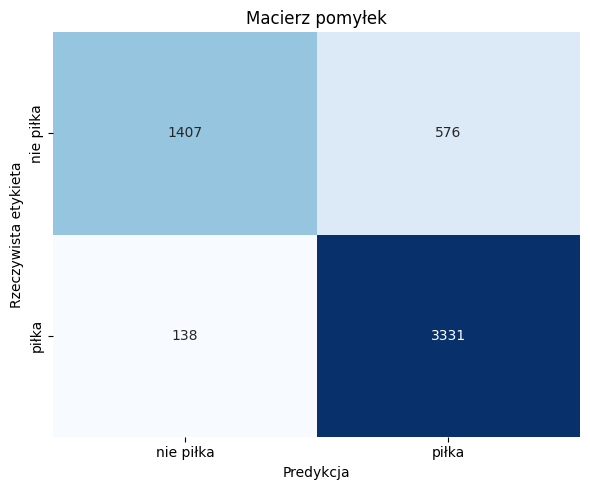

In [47]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Wykres
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["nie piłka", "piłka"],
            yticklabels=["nie piłka", "piłka"])
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista etykieta")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()